In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, optimizers, layers, metrics
from training_functions import *

In [9]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.RandomBrightness(0.2, (0, 282)))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

def architecture_3(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.RandomFlip())
    network.add(layers.RandomRotation(1))
    network.add(layers.Normalization())
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu', padding='same'))
    network.add(layers.BatchNormalization())
    network.add(layers.Flatten())
    network.add(layers.Dense(n_filters[1], activation='sigmoid'))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [10]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 15ms"
data_dir = path
model_dir = path + '/model.h5'
n_tweezers = 100
n_loops = 20


In [15]:
model = architecture_1((15, 15), [16, 8], [3, 3])
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',
               metrics=['binary_accuracy'])
model.save(model_dir)

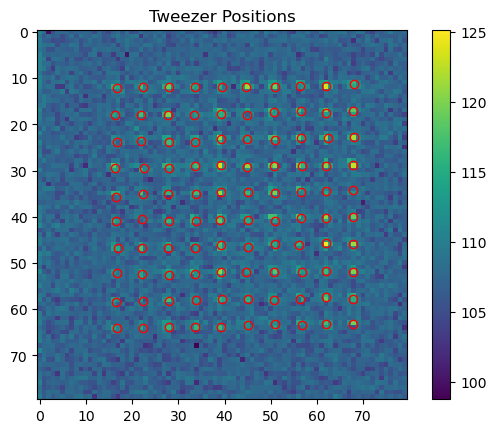

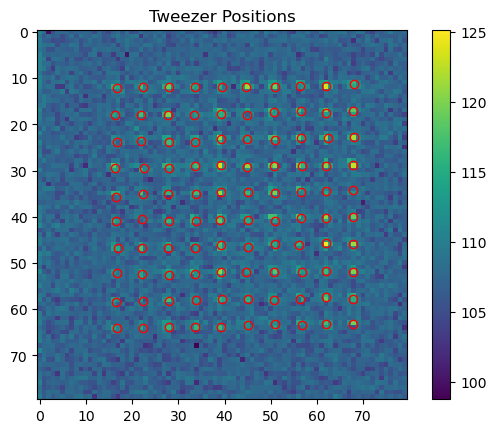

In [12]:
stack, model, n_files = load(n_loops, n_tweezers, data_dir, model_dir)
crops_3x3, crops_1x1, info = process_images(stack, n_tweezers, n_loops * n_files)
training, labeling, fidelity_crops = split_training_fidelity(crops_1x1, crops_3x3, n_loops, n_files)

INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
INFO:PipelineStages.Labeler:Making threshold plots...
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!
No images for this tweezer can be labeled dark!


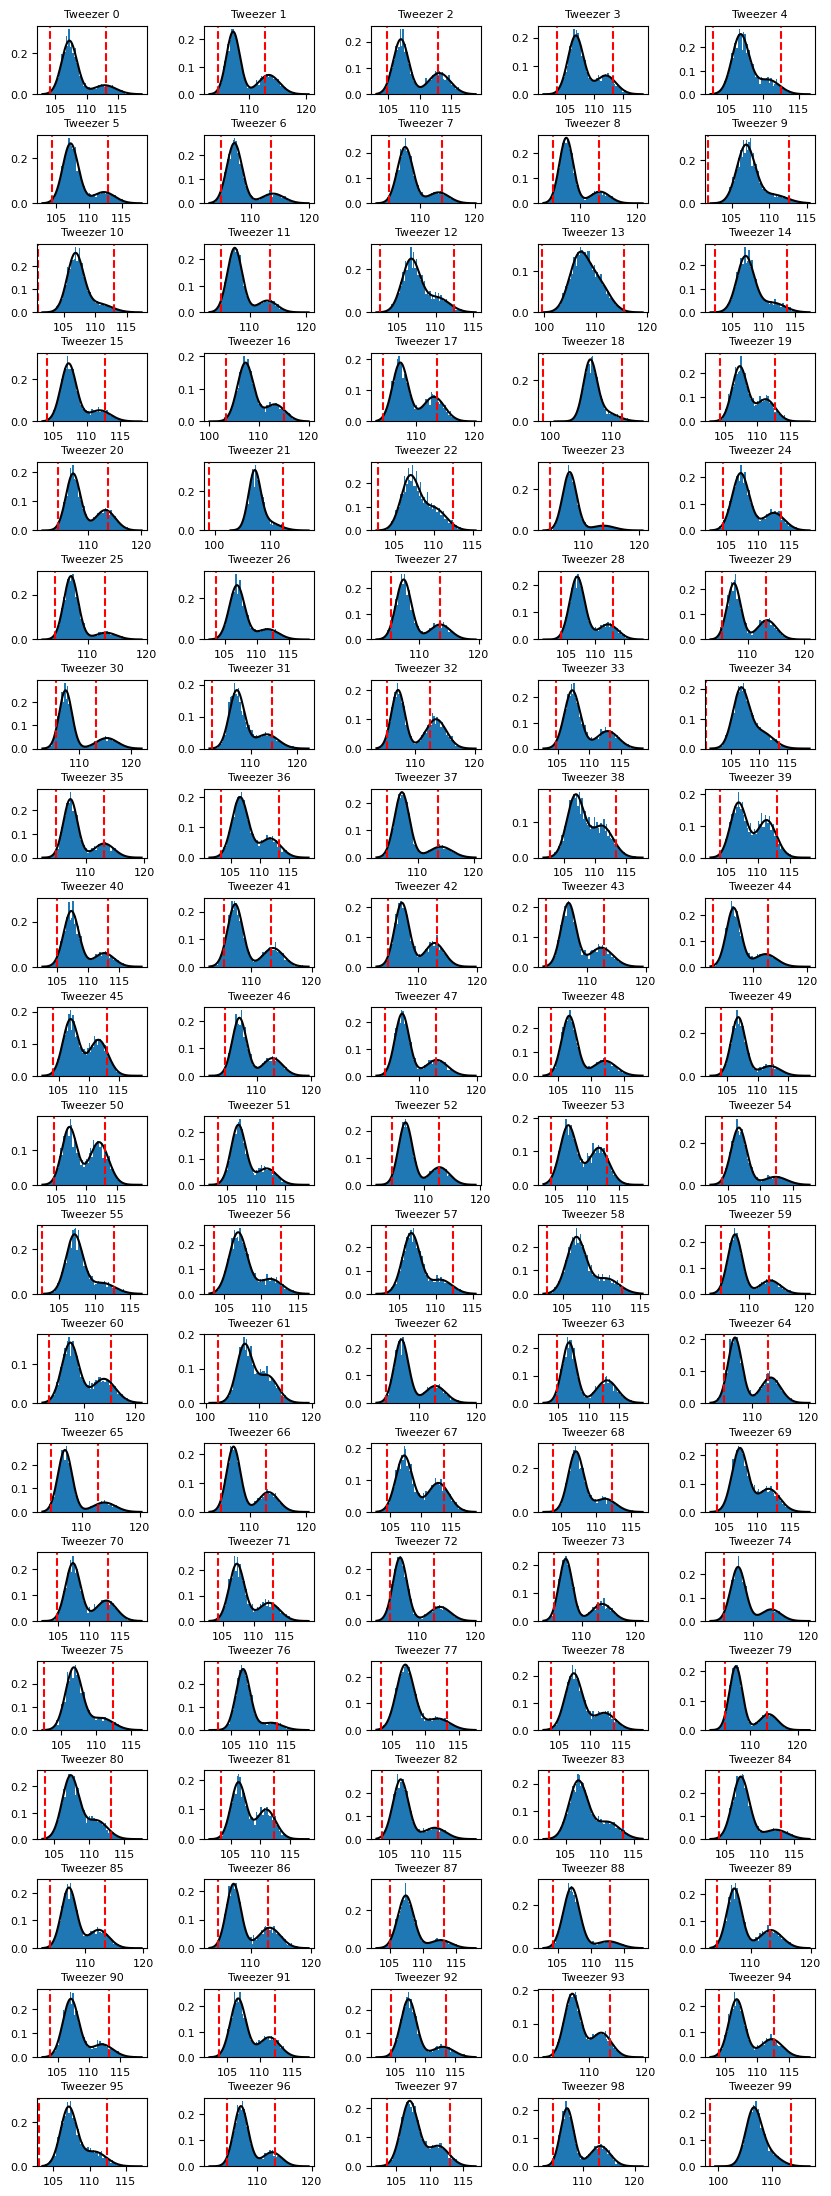

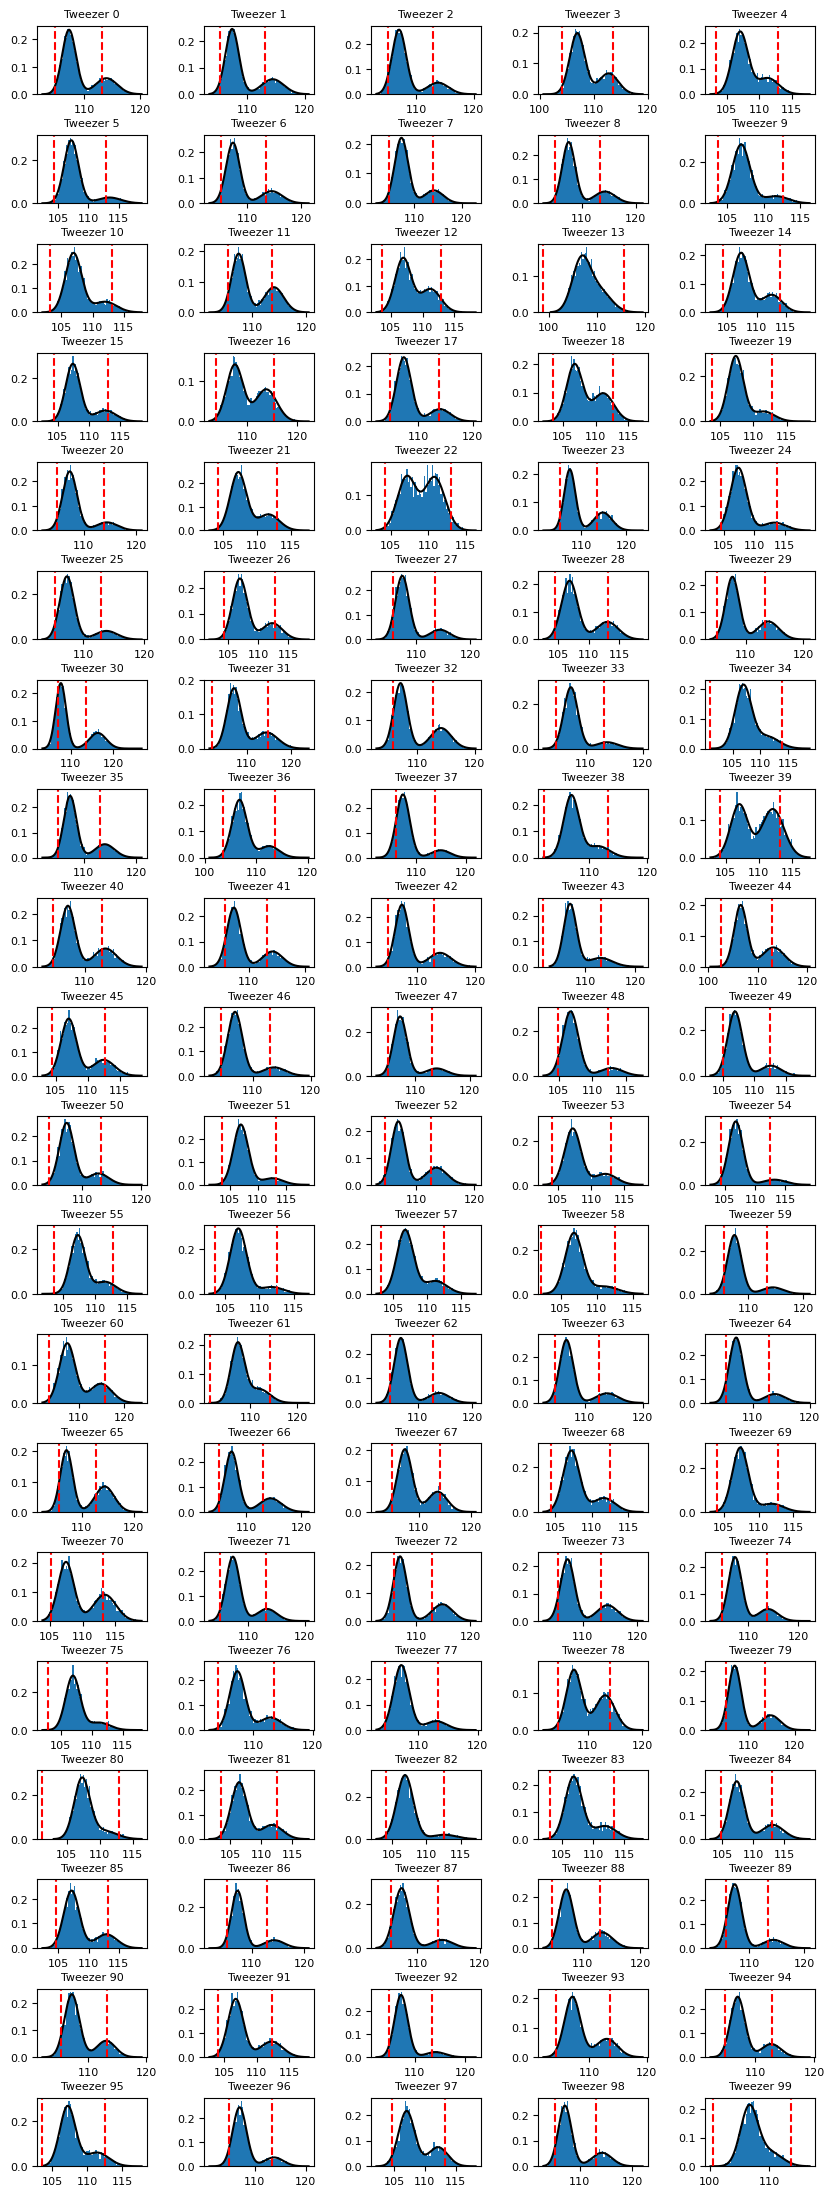

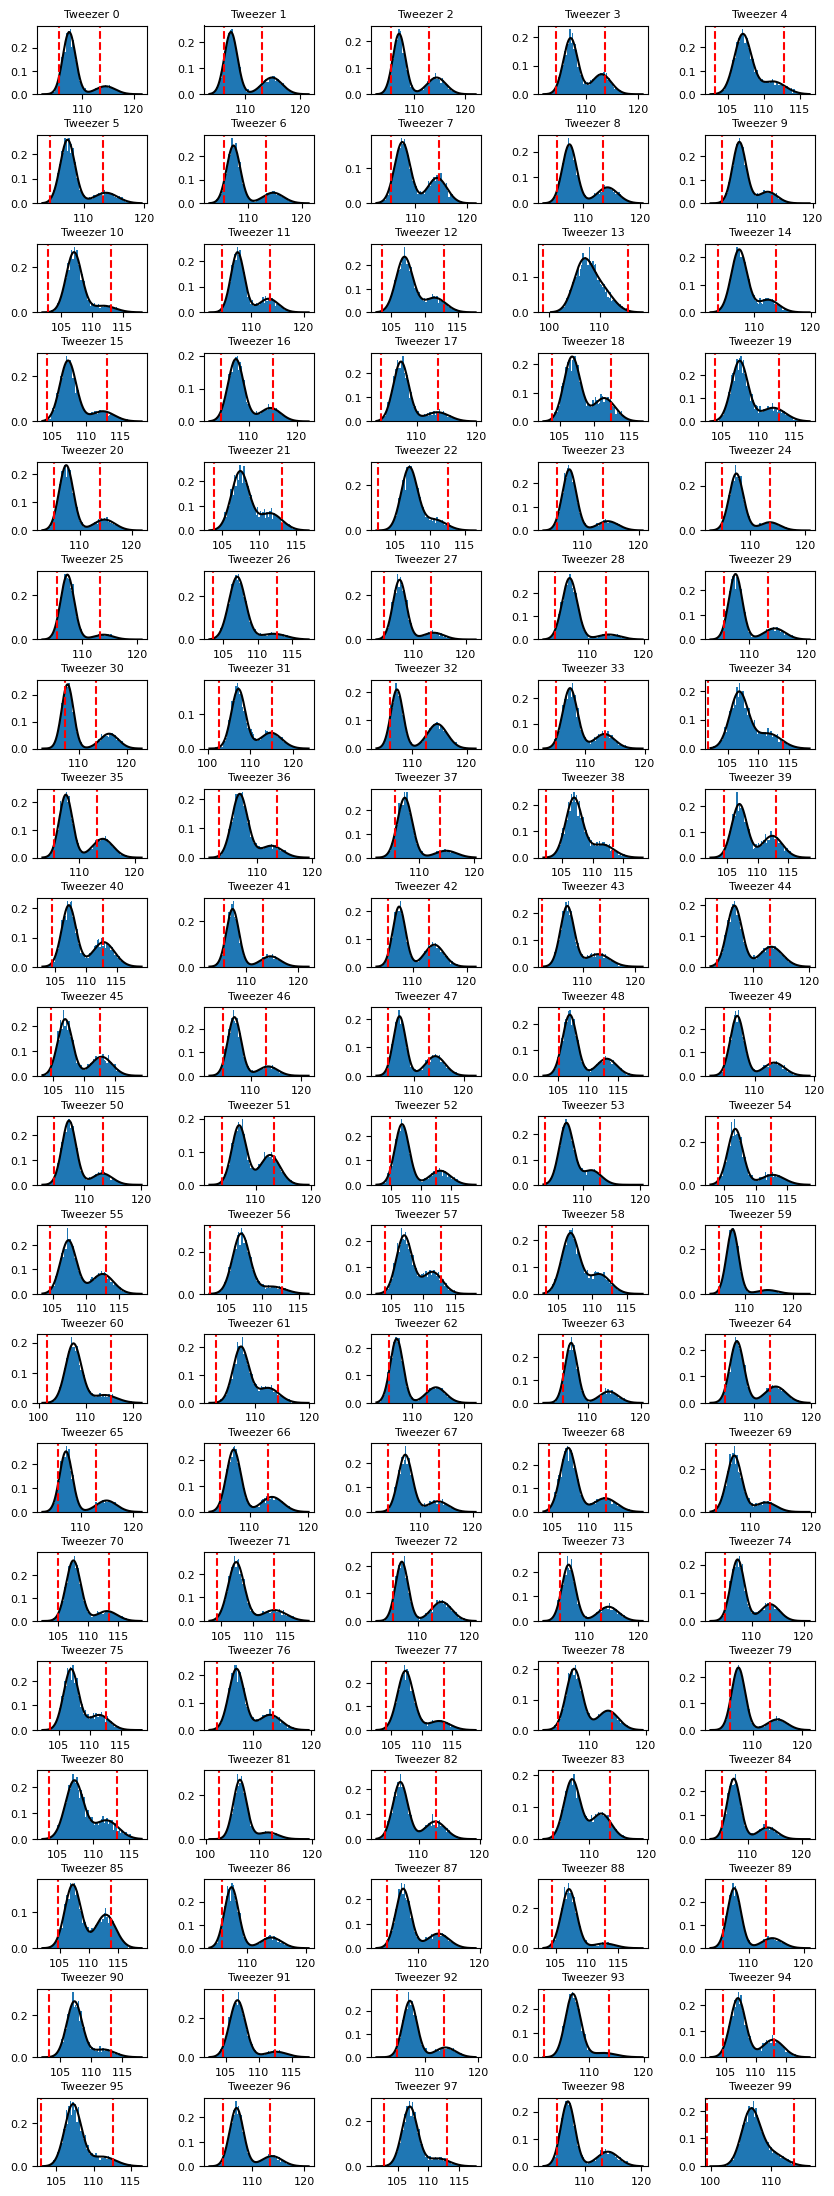

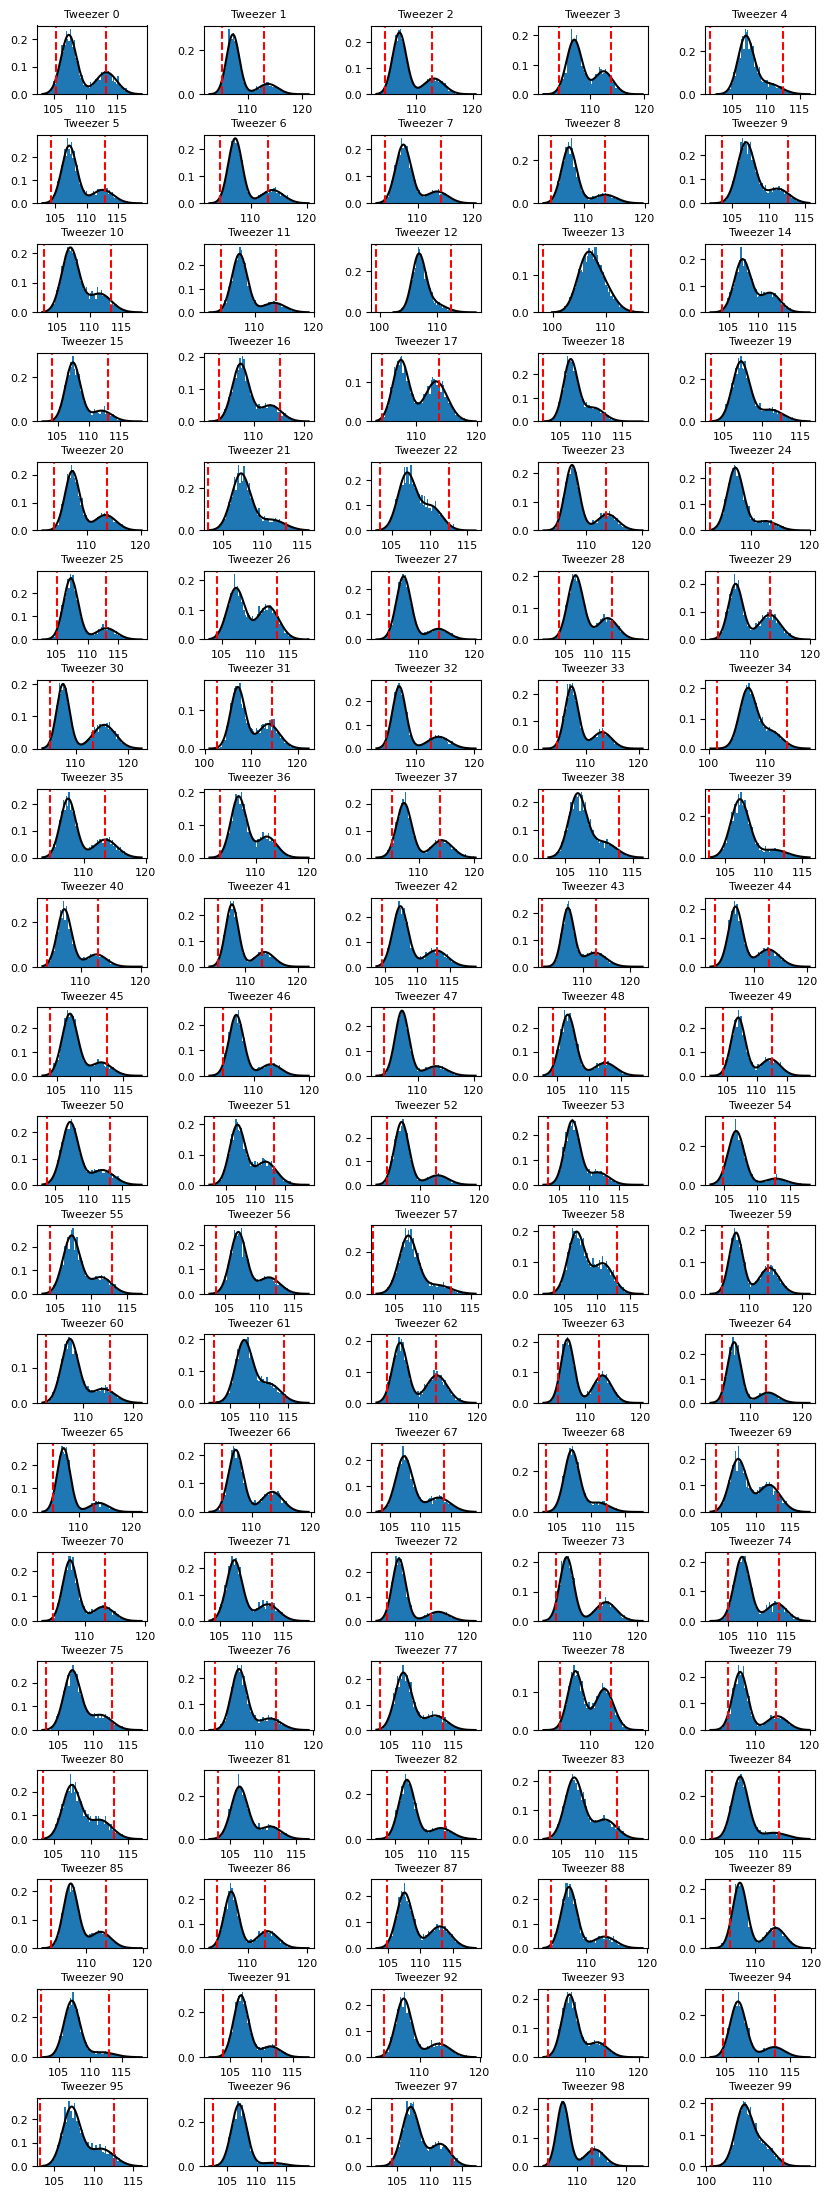

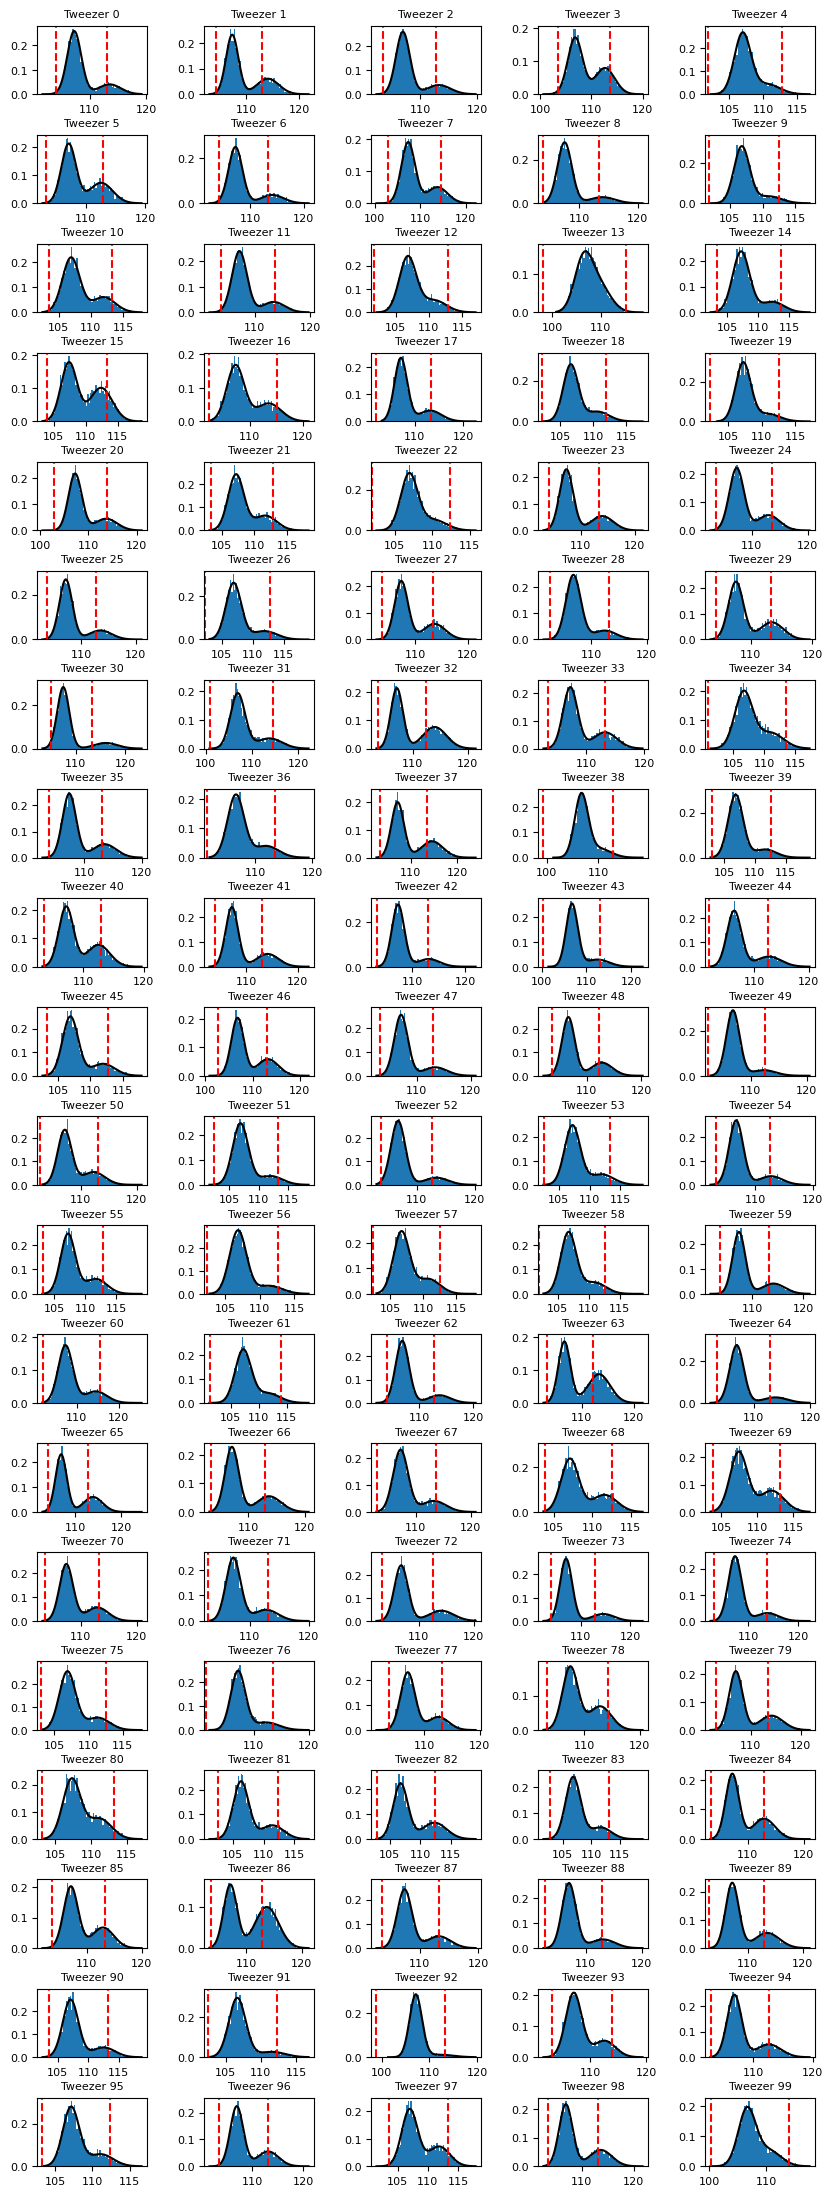

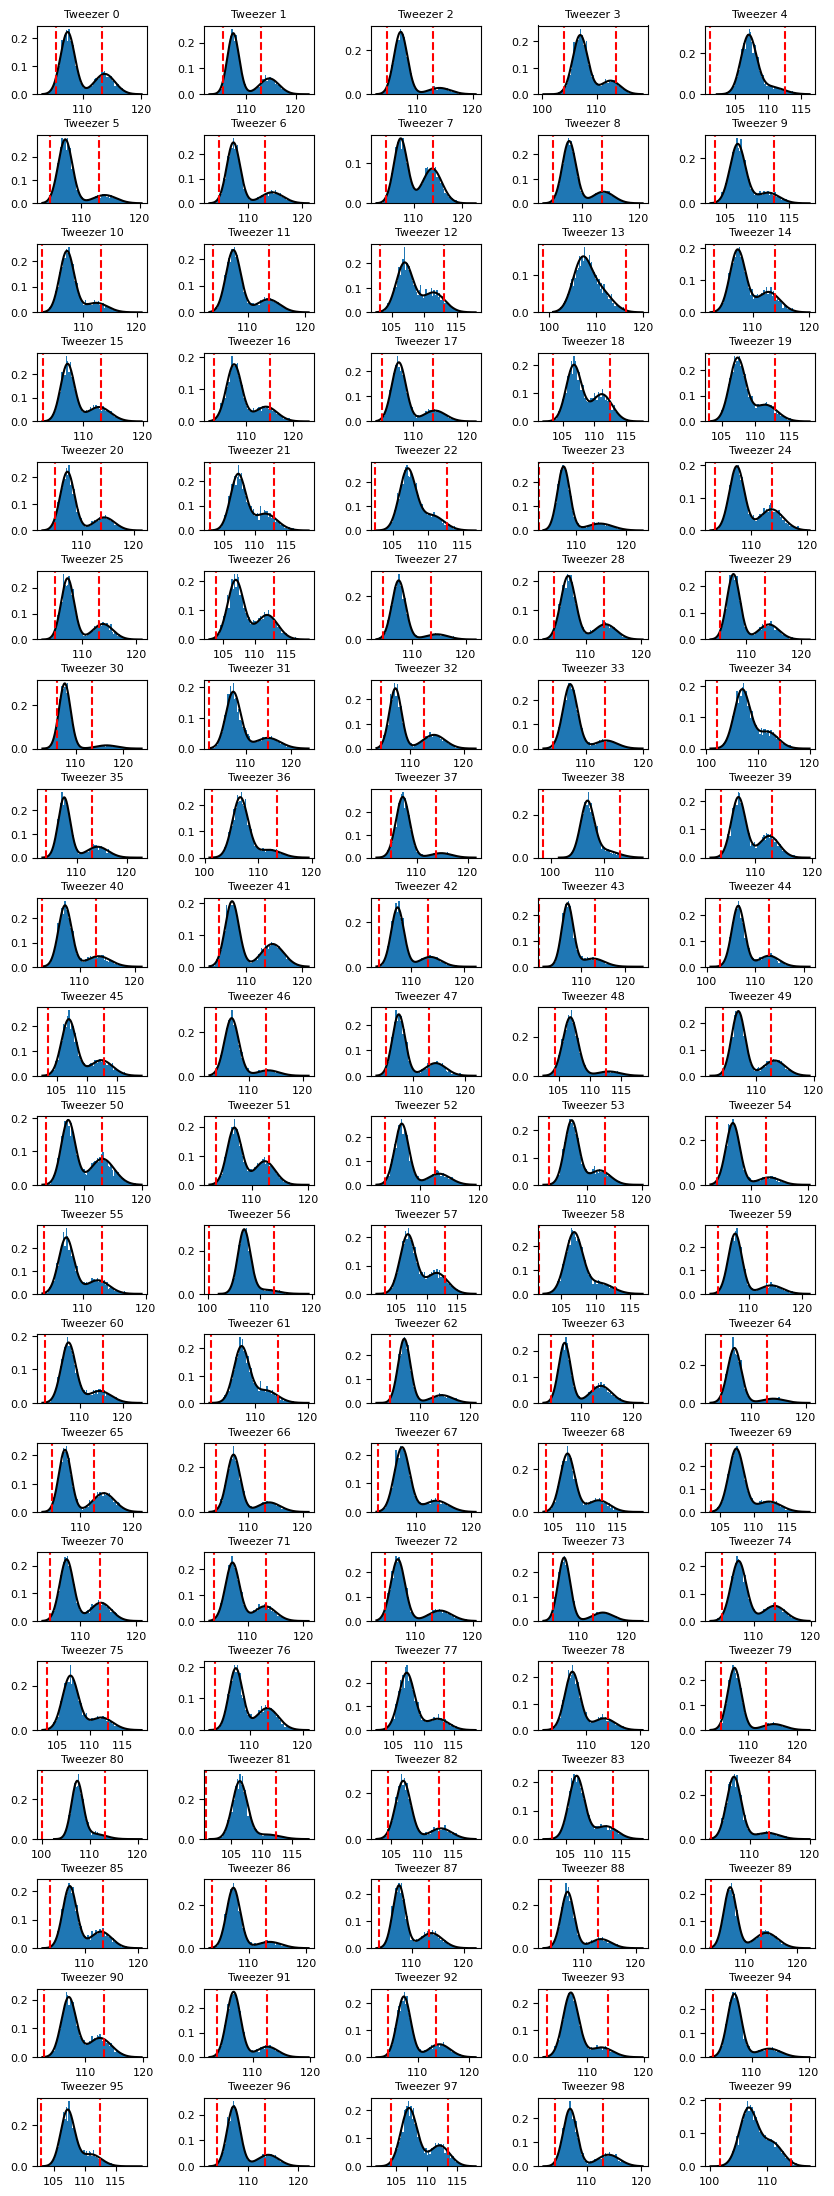

In [13]:
labels, info = label_images(labeling, n_files - 1, n_loops, n_tweezers)
training, testing, info = build_dataset(training, labels)

In [16]:
history, testing_metrics = train_model(model, training, testing)
fidelity = analyze_fidelity(model, fidelity_crops, n_loops, n_tweezers)
model.save(model_dir)

Epoch 1/8
40171/40171 [==============================] - 258s 6ms/step - loss: 0.0869 - binary_accuracy: 0.9736 - val_loss: 0.0460 - val_binary_accuracy: 0.9856
Epoch 2/8
 8227/40171 [=====>........................] - ETA: 3:08 - loss: 0.0694 - binary_accuracy: 0.9808

In [ ]:
model.evaluate(testing[0], testing[1])